# Project 2: 2-node Network Data

Instructions:
Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

(1) Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

(2) What can you infer about each of the distinct groups?

## Data

ROSENFELD,WHITE--ST. LOUIS CRIME
DATASETS CRIME SEX

DESCRIPTION One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.
BACKGROUND In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

Link: http://moreno.ss.uci.edu/data.html#crime

## Packages used

In [319]:
import requests
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Functions for Parsing Data

In [2]:
def extract_string(string:str) -> str:
    '''
    input: string
    output: string
    function cleans up string
    '''
    return string.replace('\r', '').replace('"','')

def extract_int(string:str) -> int:
    '''
    input: string
    output: integer
    function cleans up string, transforms to integer
    '''
    return int(string.replace('\r', '').replace('"','').strip())

## Call Sex Data and Produce Data Frame

In [3]:
#Extract sex data from UCI website
response = requests.get('http://moreno.ss.uci.edu/sex.dat')
data = response.text 
data_by_line = data.split('\n')

#create list of names
#first name: "AbelDennis" first
#last name: RunyonMatt
name_list = []
for name in data_by_line[4:875]:
    name_list.append(extract_string(name))

#create list of sex    
sex_list = []
for sex in data_by_line[878:-1]:
    sex_list.append(extract_int(sex))

#create dataframe concatenating informaiton
sex_df = pd.DataFrame({'name': name_list, 'sex': sex_list})
sex_df

,name,sex
0,AbelDennis,1
1,AbramsChad,1
2,AbramsDavid,1
3,AbramsDon,1
4,AbramsRichard,1
...,...,...
866,YatesAugust,1
867,YorkBrant,1
868,ParkerPete,1
869,DandyCarol,0


## Call Crime Data and Produce Data Frame 

In [5]:
response = requests.get('http://moreno.ss.uci.edu/crime.dat')
data = response.text 
data_by_line = data.split('\n')
#  870

# #first name: "AbelDennis" first
# #last name: RunyonMatt
row_idx_name_2 = []
for i in data_by_line[4:874]:
    row_idx_name_2.append(extract_string(i))


# #first column: 920001
# #last column: 970556
column_headers_list = []
for i in data_by_line[875:1432]:
    column_headers_list.append(extract_int(i))

#crime data
crime_data_list = []
for crime in data_by_line[1433:-1]:
    crime_string = extract_string(crime)
    #split string and convert to list of integers
    crime_list = []
    for i in crime_string.split():
        crime_list.append(i)    
    crime_data_list.append(crime_list)

crime_data_list

#unique identifier
unique_id_df = pd.DataFrame(list(range(0,len(sex_df['name']))))

# Create the pandas DataFrame  
crime_df = pd.DataFrame(crime_data_list, columns = column_headers_list) 
crime_df.insert(0,'name',row_idx_name_2)
crime_df.insert(0,'node',unique_id_df)
crime_df

,node,name,920001,930002,930003,930004,930005,930006,930007,930008,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,0,AbelDennis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,AbramsChad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,AbramsDavid,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,AbramsDon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,AbramsRichard,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,865,YatesAugust,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
866,866,YorkBrant,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,867,ParkerPete,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,868,DandyCarol,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Link Sex and Crime Data

In [6]:
crime_sex_df = pd.merge(sex_df, crime_df, on='name')
crime_sex_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,0,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Send data to csv

In [7]:
##Send Data to csv
crime_sex_df.to_csv('crime_sex_data.csv', header=True, index=False)

## Ensure CSV File is created properly.

In [8]:
crime_data_df = pd.read_csv('crime_sex_data.csv')

#convert females to 2 for next part 
crime_data_df.loc[crime_data_df['sex'] == 0, 'sex'] = 2
crime_data_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,2,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create Node-Edge List (node, sex, relationship, incident)
Males coded as 1, Females coded as 2

In [9]:
#Create list of all the incidents
incident_list = list(crime_data_df.columns.values)

#remove uncessary names and bad data
incident_list.remove('name')
incident_list.remove('sex')
incident_list.remove('node')
incident_list.remove('960267.1')
incident_list.remove('960247.1')
incident_list.remove('950203')

# #initialize empty array for node edge pairs
bipart_data_structure = []

for incident in incident_list:

    #create data frame with just node, sex, and incident
    incident_df = crime_data_df[['node','sex', incident]]

    #extract rows with values greater than 0
    incident_compressed_df = incident_df[(incident_df > 0).all(axis=1)]

    #create a list from the data frame
    incident_compressed_list = incident_compressed_df.values.tolist()

    for person in incident_compressed_list:
        person.append(incident)
        bipart_data_structure.append(person)

bipart_data_structure
bipart_data_structure_df = pd.DataFrame(bipart_data_structure, columns = ['node', 'sex', 'relationship', 'incident'])   
bipart_data_structure_df

,node,sex,relationship,incident
0,111,1,1,920001
1,442,2,3,930002
2,443,2,3,930002
3,444,2,3,930002
4,614,1,1,930002
...,...,...,...,...
1476,55,1,2,970556
1477,56,1,2,970556
1478,446,1,2,970556
1479,469,1,2,970556


## Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.

In [10]:
#bring in the data name
crime_data_df
bipart_data_structure_df
bipart_data_df = pd.merge(bipart_data_structure_df, crime_data_df, on='node')
bipart_data_df = bipart_data_df[['name','node','sex_x','relationship','incident']]
bipart_data_df.to_csv('bipart_crime_data.csv')
bipart_data_df

,name,node,sex_x,relationship,incident
0,BrowningCalder,111,1,1,920001
1,BrowningCalder,111,1,1,930014
2,BrowningCalder,111,1,1,930020
3,BrowningCalder,111,1,1,960369
4,BrowningCalder,111,1,1,960386
...,...,...,...,...,...
1476,FieldsWalter,272,1,1,970548
1477,DeaconHubert,219,1,2,970553
1478,LaddClarence,473,1,4,970554
1479,BenderCarlos,55,1,2,970556


## Review of Data

In [11]:
#
bipart_data_df.groupby(['name','relationship'], as_index=False)['incident'].count()
df2 = bipart_data_df.groupby(['name'], as_index=False)['incident'].count()
df2.sort_values(by=['incident'], ascending=False)

#possible domestic incident, (victims female???)
#top guy, a trouble maker, Wilson Mac
bipart_data_df[bipart_data_df['name']=='WilsonMac']

bipart_data_df[bipart_data_df['incident']=='960307']
wilsons_incidents = list(bipart_data_df[bipart_data_df['name']=='WilsonMac']['incident'])
bipart_data_df[bipart_data_df['incident'].isin(wilsons_incidents)].sort_values(by=['incident'], ascending=False)

#top five people and make graphs.  


,name,node,sex_x,relationship,incident
1063,WilsonMac,854,1,2,970550
471,CusackJill,208,2,1,970550
1171,JohnsonJack,432,1,1,970526
1062,WilsonMac,854,1,2,970526
1061,WilsonMac,854,1,2,970521
1003,WilliamsRoosevelt,848,1,2,970521
1443,BrownLeonard,108,1,1,970521
779,SmithAnthony,725,1,2,970521
1038,SaxeGina,697,2,1,970495
1060,WilsonMac,854,1,2,970495


In [12]:
#extract males from the dataset 
males = bipart_data_df['sex_x']==1
bipart_data_males_df = bipart_data_df[bipart_data_df['sex_x']==1]

# number of unique events that males are in 
bipart_data_males_df['incident'].nunique()
#males are in 491 events


491

## Prep and Import data into Networkx Graph

In [14]:
#Prepare edge data
edges = pd.read_csv('bipart_crime_data.csv')
edges['weight'] = 2
edges = edges[['name','sex_x','relationship','incident','weight']]
edges = edges.rename(columns={'name': 'source', 'sex_x':'source_sex', 'incident':'target', 'relationship':'value'})

In [15]:
#create graph and add edges
g = nx.from_pandas_edgelist(edges, edge_attr=True)

In [16]:
for person, incident, edge_data in g.edges(data=True):
    print(person, incident, edge_data)

BrowningCalder 920001 {'source_sex': 1, 'value': 1, 'weight': 2}
BrowningCalder 930014 {'source_sex': 1, 'value': 1, 'weight': 2}
BrowningCalder 930020 {'source_sex': 1, 'value': 1, 'weight': 2}
BrowningCalder 960369 {'source_sex': 1, 'value': 1, 'weight': 2}
BrowningCalder 960386 {'source_sex': 1, 'value': 1, 'weight': 2}
BrowningCalder 970496 {'source_sex': 1, 'value': 1, 'weight': 2}
930020 BrowningDarnell {'source_sex': 1, 'value': 2, 'weight': 2}
930020 CorleyDanette {'source_sex': 2, 'value': 1, 'weight': 2}
960369 GarnerMickey {'source_sex': 1, 'value': 2, 'weight': 2}
960369 PhillipsSam {'source_sex': 1, 'value': 2, 'weight': 2}
960369 WilsonLuke {'source_sex': 1, 'value': 2, 'weight': 2}
960386 SwiftMaurice {'source_sex': 1, 'value': 2, 'weight': 2}
970496 StackBarbara {'source_sex': 2, 'value': 2, 'weight': 2}
KarstenBonnie 930002 {'source_sex': 2, 'value': 3, 'weight': 2}
930002 KarstenLinda {'source_sex': 2, 'value': 3, 'weight': 2}
930002 KarstenMae {'source_sex': 2, 'valu

950228 InvernessBen {'source_sex': 1, 'value': 2, 'weight': 2}
SimpsonBart 940096 {'source_sex': 1, 'value': 1, 'weight': 2}
SimpsonBart 950213 {'source_sex': 1, 'value': 1, 'weight': 2}
SimpsonBart 970469 {'source_sex': 1, 'value': 2, 'weight': 2}
SimpsonBart 970545 {'source_sex': 1, 'value': 2, 'weight': 2}
940096 SimpsonAdella {'source_sex': 2, 'value': 3, 'weight': 2}
940096 ThompsonBert {'source_sex': 1, 'value': 2, 'weight': 2}
950213 SimpsonAdella {'source_sex': 2, 'value': 1, 'weight': 2}
950213 ThompsonAndy {'source_sex': 1, 'value': 1, 'weight': 2}
950213 WilburDean {'source_sex': 1, 'value': 1, 'weight': 2}
970469 DuncanOrrin {'source_sex': 1, 'value': 3, 'weight': 2}
970469 DuncanScott {'source_sex': 1, 'value': 3, 'weight': 2}
970469 MorlandKate {'source_sex': 2, 'value': 1, 'weight': 2}
970545 ThompsonAndy {'source_sex': 1, 'value': 1, 'weight': 2}
970545 ElliottRed {'source_sex': 1, 'value': 2, 'weight': 2}
970545 ThompsonTreavor {'source_sex': 1, 'value': 2, 'weight': 2

940100 DaleMike {'source_sex': 1, 'value': 2, 'weight': 2}
940100 KenneyMarcus {'source_sex': 1, 'value': 1, 'weight': 2}
940100 PurcellGreg {'source_sex': 1, 'value': 3, 'weight': 2}
940100 TandyAmos {'source_sex': 1, 'value': 1, 'weight': 2}
MyersRicky 930066 {'source_sex': 1, 'value': 1, 'weight': 2}
MyersRicky 940092 {'source_sex': 1, 'value': 1, 'weight': 2}
MyersRicky 940117 {'source_sex': 1, 'value': 2, 'weight': 2}
MyersRicky 950165 {'source_sex': 1, 'value': 1, 'weight': 2}
MyersRicky 950199 {'source_sex': 1, 'value': 2, 'weight': 2}
MyersRicky 960264 {'source_sex': 1, 'value': 1, 'weight': 2}
MyersRicky 970413 {'source_sex': 1, 'value': 2, 'weight': 2}
930066 SellersDoris {'source_sex': 2, 'value': 1, 'weight': 2}
930066 VincentKenneth {'source_sex': 1, 'value': 1, 'weight': 2}
940092 VincentKenneth {'source_sex': 1, 'value': 1, 'weight': 2}
940092 AlexanderDevon {'source_sex': 1, 'value': 1, 'weight': 2}
940092 AlexanderTrina {'source_sex': 2, 'value': 1, 'weight': 2}
940117

970556 KirbyRobertT {'source_sex': 1, 'value': 2, 'weight': 2}
BenderChris 970531 {'source_sex': 1, 'value': 1, 'weight': 2}
970531 DysonBert {'source_sex': 1, 'value': 1, 'weight': 2}
970531 EaganLowell {'source_sex': 1, 'value': 1, 'weight': 2}
970531 MerrickCarter {'source_sex': 1, 'value': 1, 'weight': 2}
970531 PowersErnest {'source_sex': 1, 'value': 1, 'weight': 2}
970531 SinclairJanice {'source_sex': 2, 'value': 1, 'weight': 2}
970531 SpinnerJudy {'source_sex': 2, 'value': 1, 'weight': 2}
970531 ThomasMarcia {'source_sex': 2, 'value': 1, 'weight': 2}
JonesEzekial 960379 {'source_sex': 1, 'value': 2, 'weight': 2}
960379 SmothersFreddie {'source_sex': 1, 'value': 2, 'weight': 2}
RhodesGarrett 950193 {'source_sex': 1, 'value': 2, 'weight': 2}
950193 EdwardsKim {'source_sex': 2, 'value': 1, 'weight': 2}
SmothersFreddie 960325 {'source_sex': 1, 'value': 2, 'weight': 2}
SmothersFreddie 960336 {'source_sex': 1, 'value': 2, 'weight': 2}
SmothersFreddie 970399 {'source_sex': 1, 'value': 

970508 RogersKerry {'source_sex': 1, 'value': 2, 'weight': 2}


## Initial Graph Shows Clusters of Activity

This is perhaps and indidication of some sort of organize crime

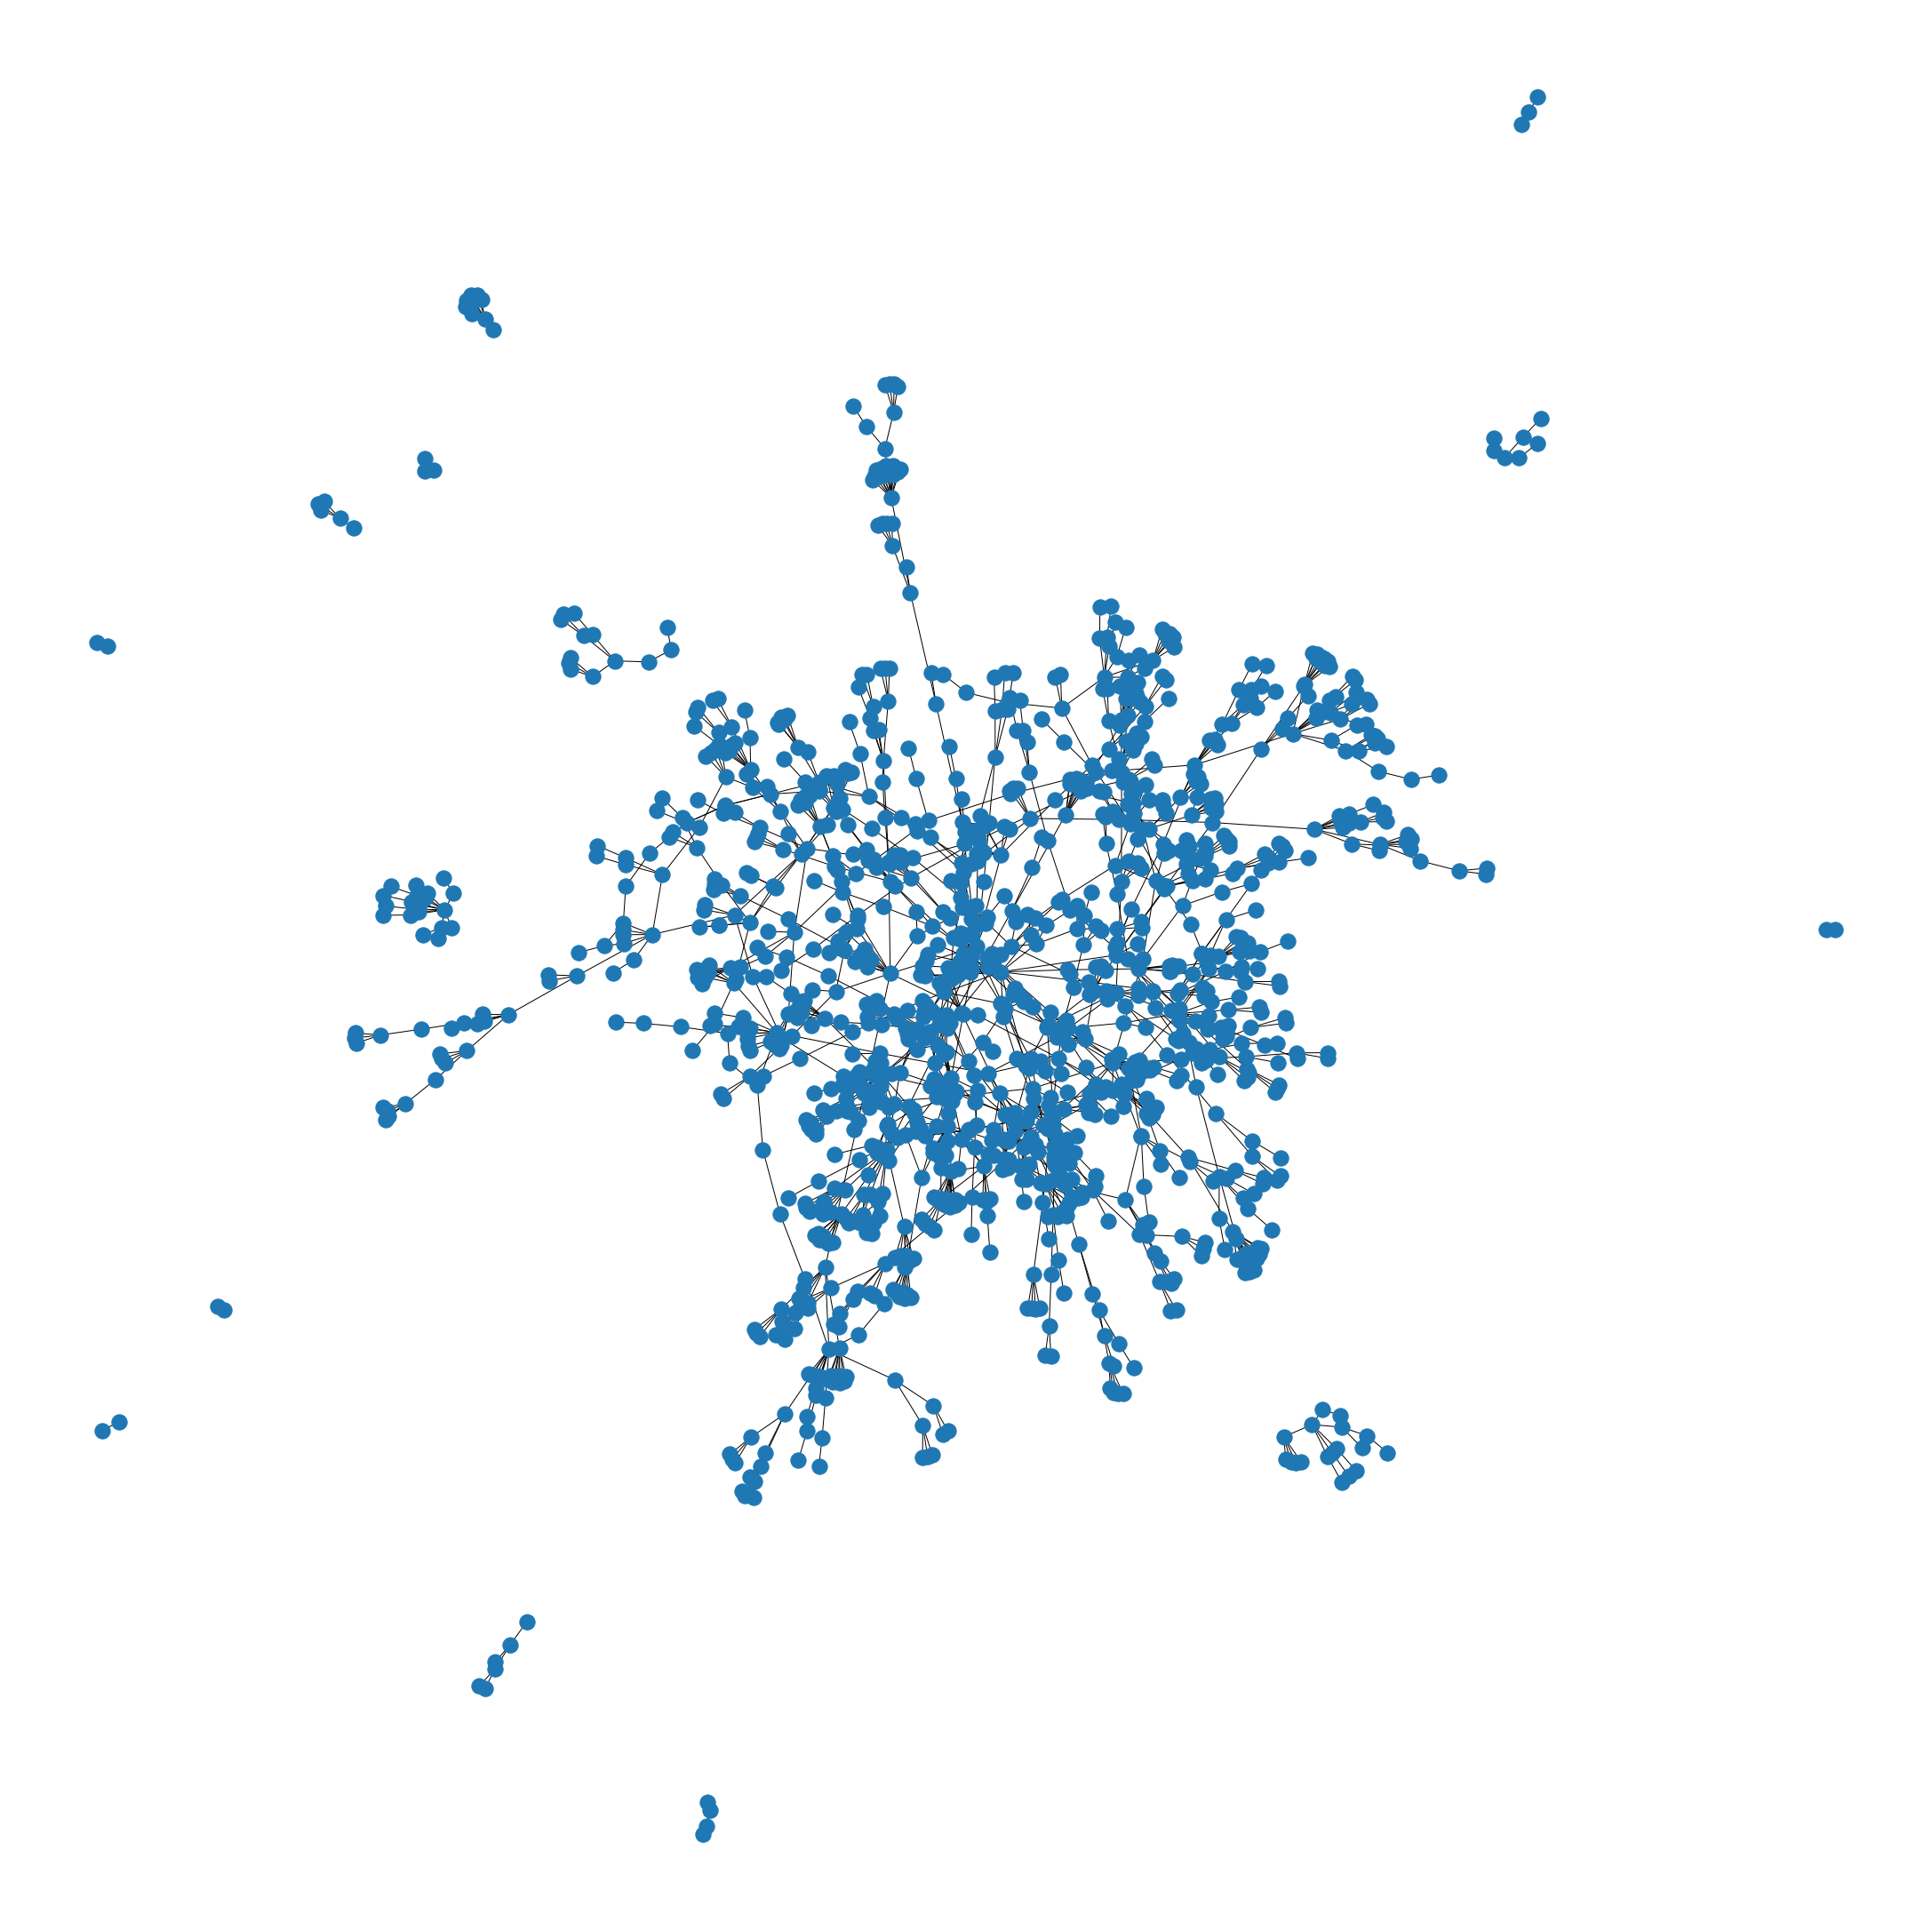

In [16]:
#Generate graph
plt.figure(figsize=(30,30))  
nx.draw(g)
#too dense, may have to use snowball sampling 

## Calculation of Weights and Island Method Functions

Island methods splits up the giant component into smaller components, and the subcomponents are individually analyzed.  We will use this method to extract areas with the strongest amount of crime activity.  To employ the island method, we used used the Newman Method discussed in the Tore Opsahl's "Projection" paper with discussed weighted two-node networks for co-occurences.  We used thes ame method discussed in the paper which described co-collaborators on a published paper.  We applied this same logic to applying weights to for parties involved in the same incident.  

In [139]:
def calculate_weight(num_people_in_incident:list) -> float:
    '''
    Newman (2001) Method from Tore Opsahl's "Projection", Weighted Two-Node Networks for Co-occurence
    https://toreopsahl.com/tnet/two-mode-networks/projection/
    input: List of People in the Incident
    output: weight calculated by number of people in the incident.
    '''
    weight = 0.0
    
    num_people_in_incident = len(persons_in_incident_list)
    
    if num_people_in_incident > 2:
        weight = 1.0/(num_people_in_incident-1)
    elif num_people_in_incident == 2:
        weight = 1.0
    else: 
        weight = 0.0
        
    return(weight)

#create al ist of all distinct incidents
incidents_list = list(set(bipart_data_df['incident']))
# #transform that list of sets into a list of lists 
incident_pairs_list = [list(combo) for combo in incident_pairs_tuple] 

#create a list of co-oc 
co_occurence_list = []
#STEP ONE: loop throught all events
for incident in incidents_list:
    #STEP TWO: create a list of all individuals involved in the indivdiual event incident
    persons_in_incident_list = list(bipart_data_df[(bipart_data_df.incident == incident)]['name'])
    #STEP THREE: Create a combinations of all Iindividuals listed in that event
    for pair in [list(combo) for combo in itertools.combinations(persons_in_incident_list, 2)]:
        co_occurence_list.append(pair)


#append 0 to all pairs
for pairs in co_occurence_list:
    pairs.append(0)

    
#Step One: loop through Incident List
for incident in incidents_list:
    #Step Two: Create a list of individuals involved in the incident
    persons_in_incident_list = list(bipart_data_df[(bipart_data_df.incident == incident)]['name'])
    
    #Step Three loop through the combination of pairs
    for pair_id, pairs in enumerate(co_occurence_list):
        person_one = pairs[0]
        person_two = pairs[1]
        
        #if both individuals appear int he list, calculate the weight
        if all(x in persons_in_incident_list for x in [person_one, person_two]):
        
            #calculate the weight
            weight = calculate_weight(num_people_in_incident)
            #add the weight to the current running total
            co_occurence_list[pair_id][2] += weight

#create Pandas DataFrame and csv file
co_occurence_df = pd.DataFrame(co_occurence_list)
#rename columns
co_occurence_df.columns = ['node', 'edge','weight']
#send dataframe to csv 
co_occurence_df.to_csv('co_occurence_weights.csv', header=True, index=False)

## Pull Data from csv and Add Sex 

In [341]:
#pull data from csv to add sex
co_occurence_df = pd.read_csv('co_occurence_weights.csv')
co_occurence_df.columns = ['name', 'edge','weight']
co_occurence_df2 = pd.merge(co_occurence_df, sex_df, on='name', how='left')
co_occurence_df2.columns = ['node', 'name','weight','node_sex']
co_occurence_df3 = pd.merge(co_occurence_df2, sex_df, on='name', how='left')
co_occurence_df3.columns = ['node', 'name','weight','node_sex', 'edge_sex']
co_occurence_df3
# co_occurence_df3.to_csv('co_occurence_weights_sex.csv', header=True, index=False)


,node,name,weight,node_sex,edge_sex
0,BendixJerryLee,JohnstonJustin,1.250000,1,1
1,JonesHarris,McConnellPhyllis,0.333333,1,0
2,JonesHarris,FlowersSteve,0.333333,1,1
3,JonesHarris,StevensonMike,0.333333,1,1
4,McConnellPhyllis,FlowersSteve,0.333333,0,1
...,...,...,...,...,...
2352,BarretScott,LowellConrad,0.333333,1,1
2353,GliddenStan,LowellConrad,0.333333,1,1
2354,DerbyTammy,DerbyNeil,1.000000,0,1
2355,SwiftMaurice,DeaconHubert,1.000000,1,1


## Revie Edge Data with Weights

In [342]:
#Prepare edge data
edges_co_df = pd.read_csv('co_occurence_weights_sex.csv')
edges_co_df.columns = ['source', 'target', 'weight', 'source_sex', 'target_sex']
edges_co_df

,source,target,weight,source_sex,target_sex
0,BendixJerryLee,JohnstonJustin,1.250000,1,1
1,JonesHarris,McConnellPhyllis,0.333333,1,0
2,JonesHarris,FlowersSteve,0.333333,1,1
3,JonesHarris,StevensonMike,0.333333,1,1
4,McConnellPhyllis,FlowersSteve,0.333333,0,1
...,...,...,...,...,...
2352,BarretScott,LowellConrad,0.333333,1,1
2353,GliddenStan,LowellConrad,0.333333,1,1
2354,DerbyTammy,DerbyNeil,1.000000,0,1
2355,SwiftMaurice,DeaconHubert,1.000000,1,1


# Load Data into NetworkX

In [228]:
#create graph and add edges
gc = nx.from_pandas_edgelist(edges_co_df, edge_attr=True)

## Generate Graph of All Data

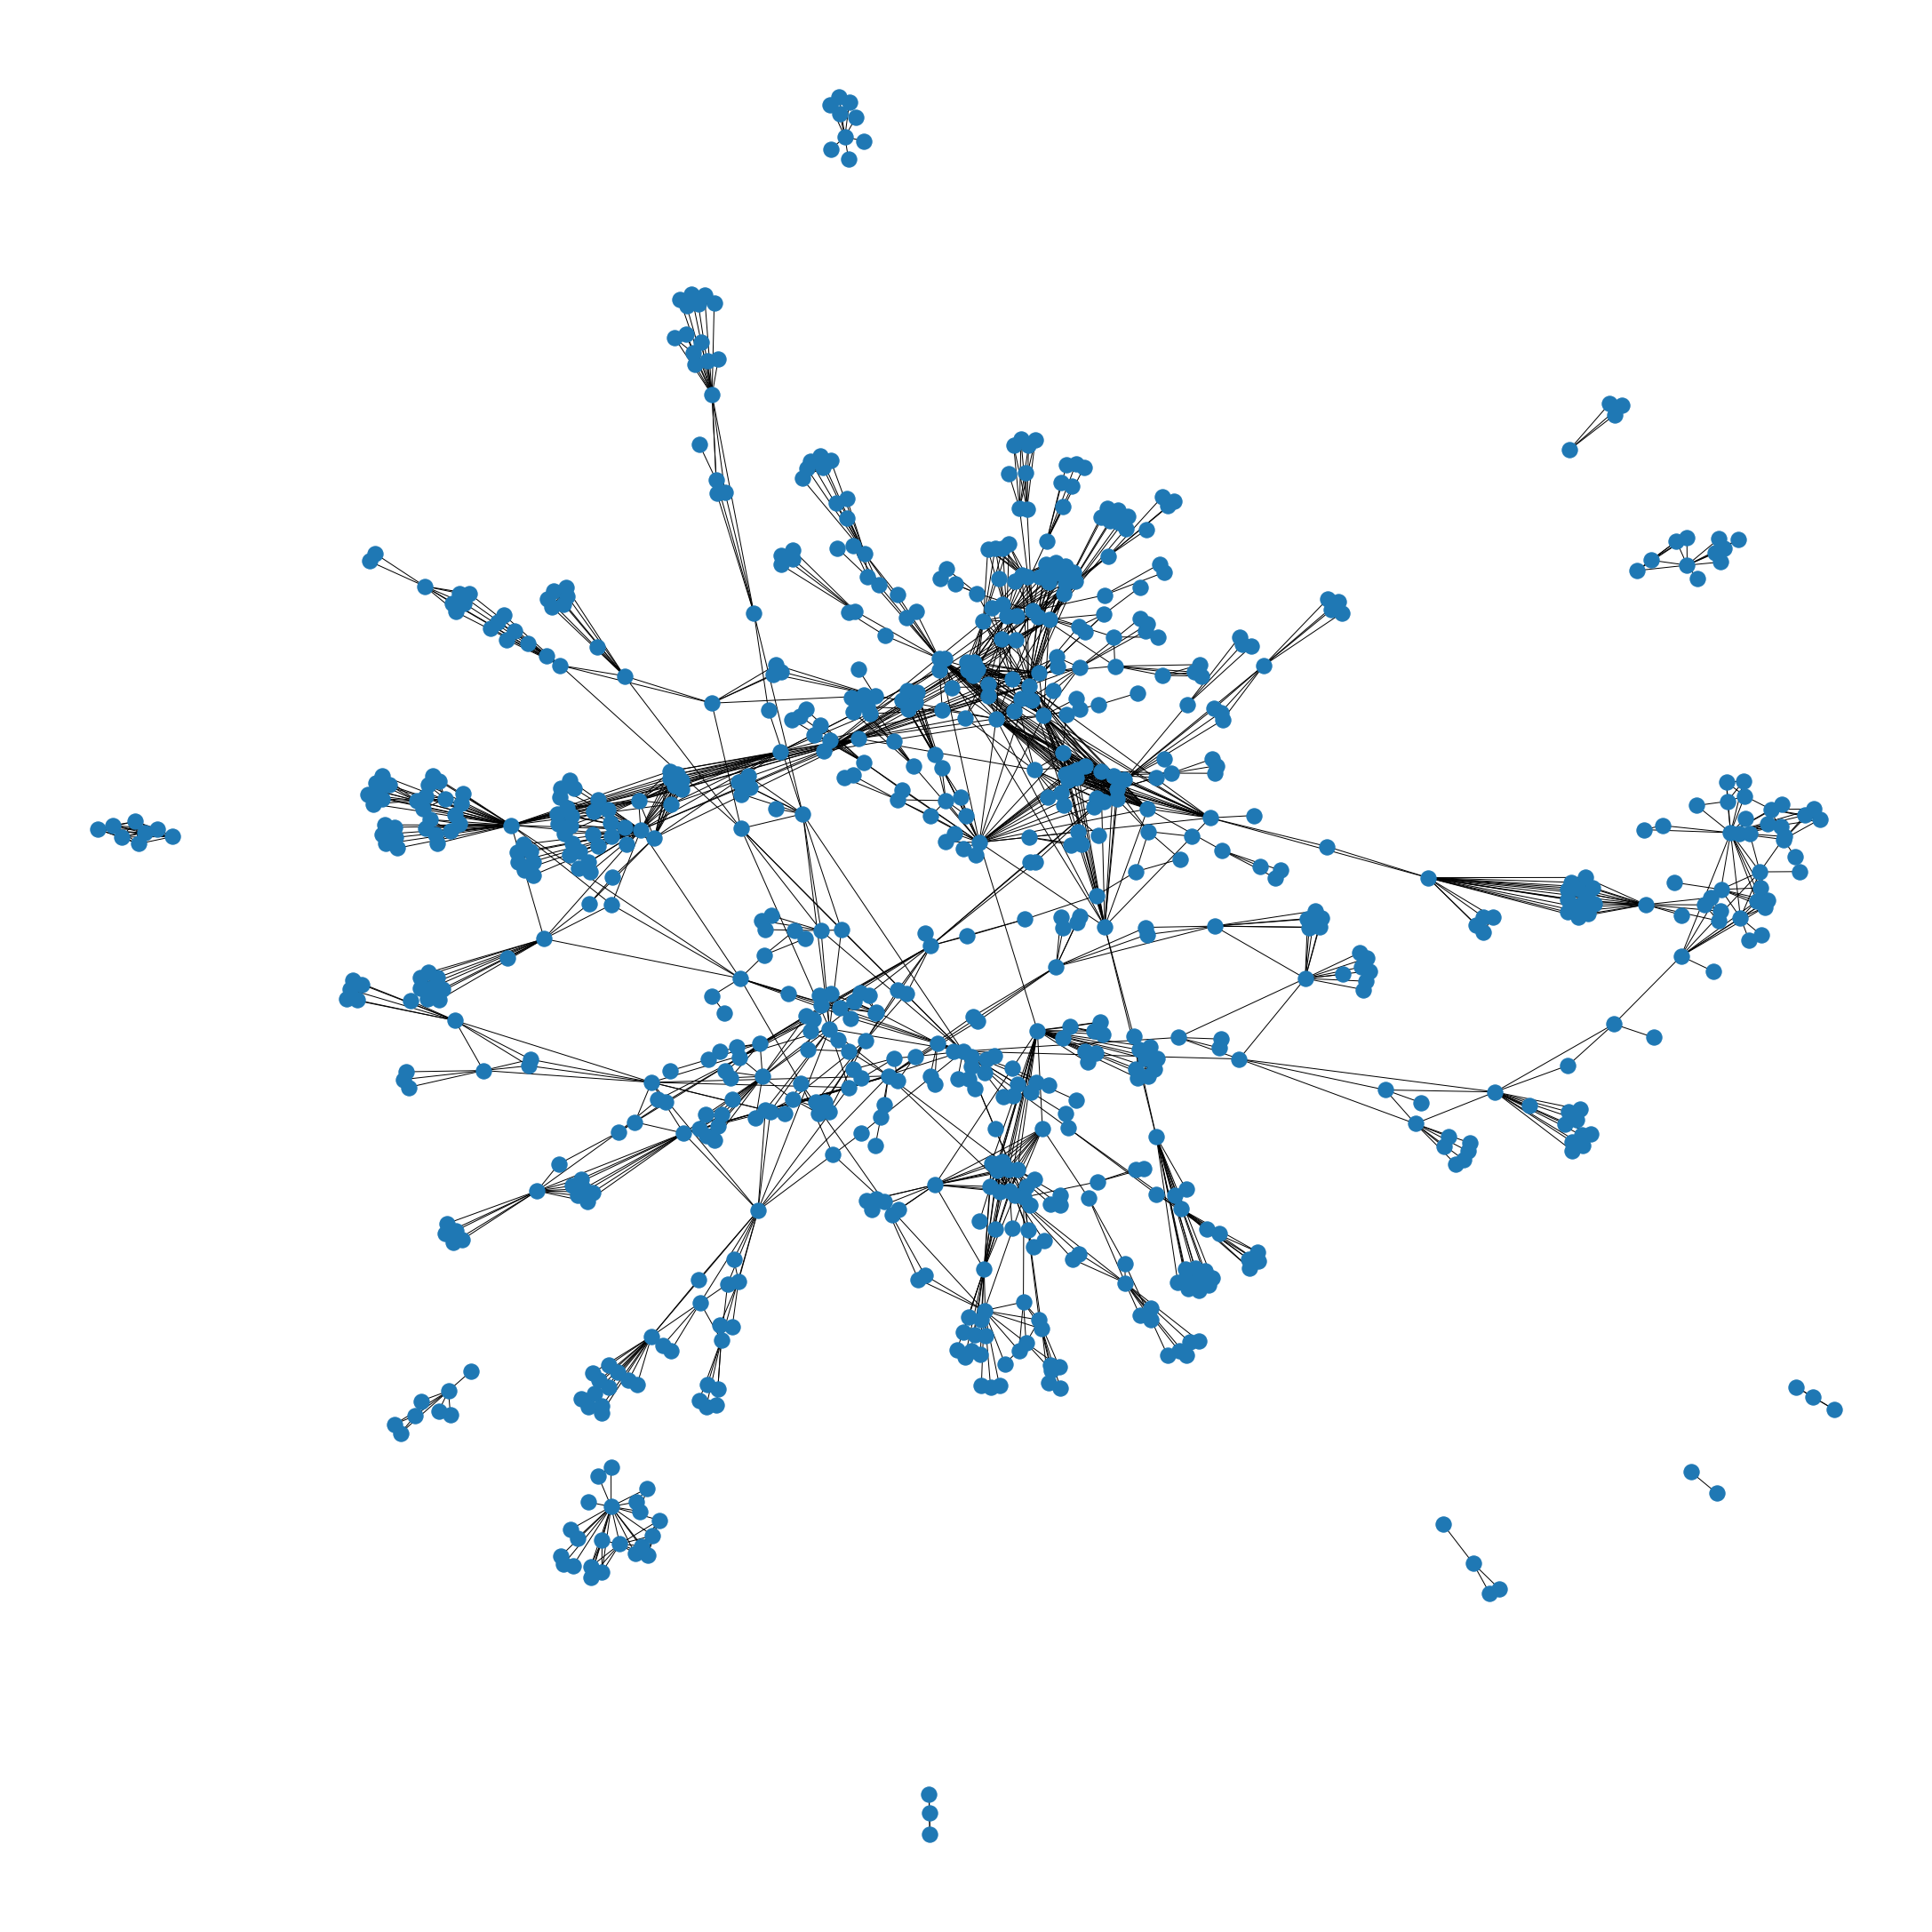

In [229]:
#Generate graph
plt.figure(figsize=(30,30))  
nx.draw(gc)
#too dense, may have to use snowball sampling 

# Island Method Functions 

Below are the functions used in employing the Island method.  We used the code referenced in Chapter 4 of Social Network Analysis.  This code is tailored for low weight situations.  

In [351]:
#trim edges function
def trim_edges(graph: object, weight=1.0) -> object:
    '''
    Input: Graph and Weight Threshold
    Output: Modified graph object 
    trim_edges fncn takes a graph and filters the weight, i.e., "water level"
    All edges above a specified threshold are retained.  
    '''
    node_edge_list = []
    for node, edge, edata in g.edges(data=True):
        if edata['weight'] > weight:
            x = [node, edge, edata['weight'], edata['source_sex'], edata['target_sex']]
            node_edge_list.append(x)
    
    node_edge_list_df = pd.DataFrame(node_edge_list)
    node_edge_list_df.columns = ['source', 'target', 'weight', 'source_sex', 'target_sex']
    g2 = nx.from_pandas_edgelist(node_edge_list_df, edge_attr=True)
    return g2

#island method function, uses trim edges
def island_method(graph: object, iterations=5) -> list:
    '''
    Input: Graph Object
    Output: List of sub graphs and the size.  
    Application of the island method.      
    '''

    #create a list of weights from the specificed graph
    weights = [edata['weight'] for node, edge, edata in g.edges(data=True)]
    
    mn = min(weights)
    mx = max(weights)
    
    #compute the size of the step, so we get a reasonable step in iterations
    step = (mx-mn)/iterations

    return [[threshold, trim_edges(g, threshold)] for threshold in np.arange(mn,mx,step)]

def connected_component_subgraphs(graph: object) -> object:
    for c in nx.connected_components(g):
        yield g.subgraph(c)

## Trim Weights to Generate SubGraphs

From this graph we can see that there are many dyads, triads, etc.

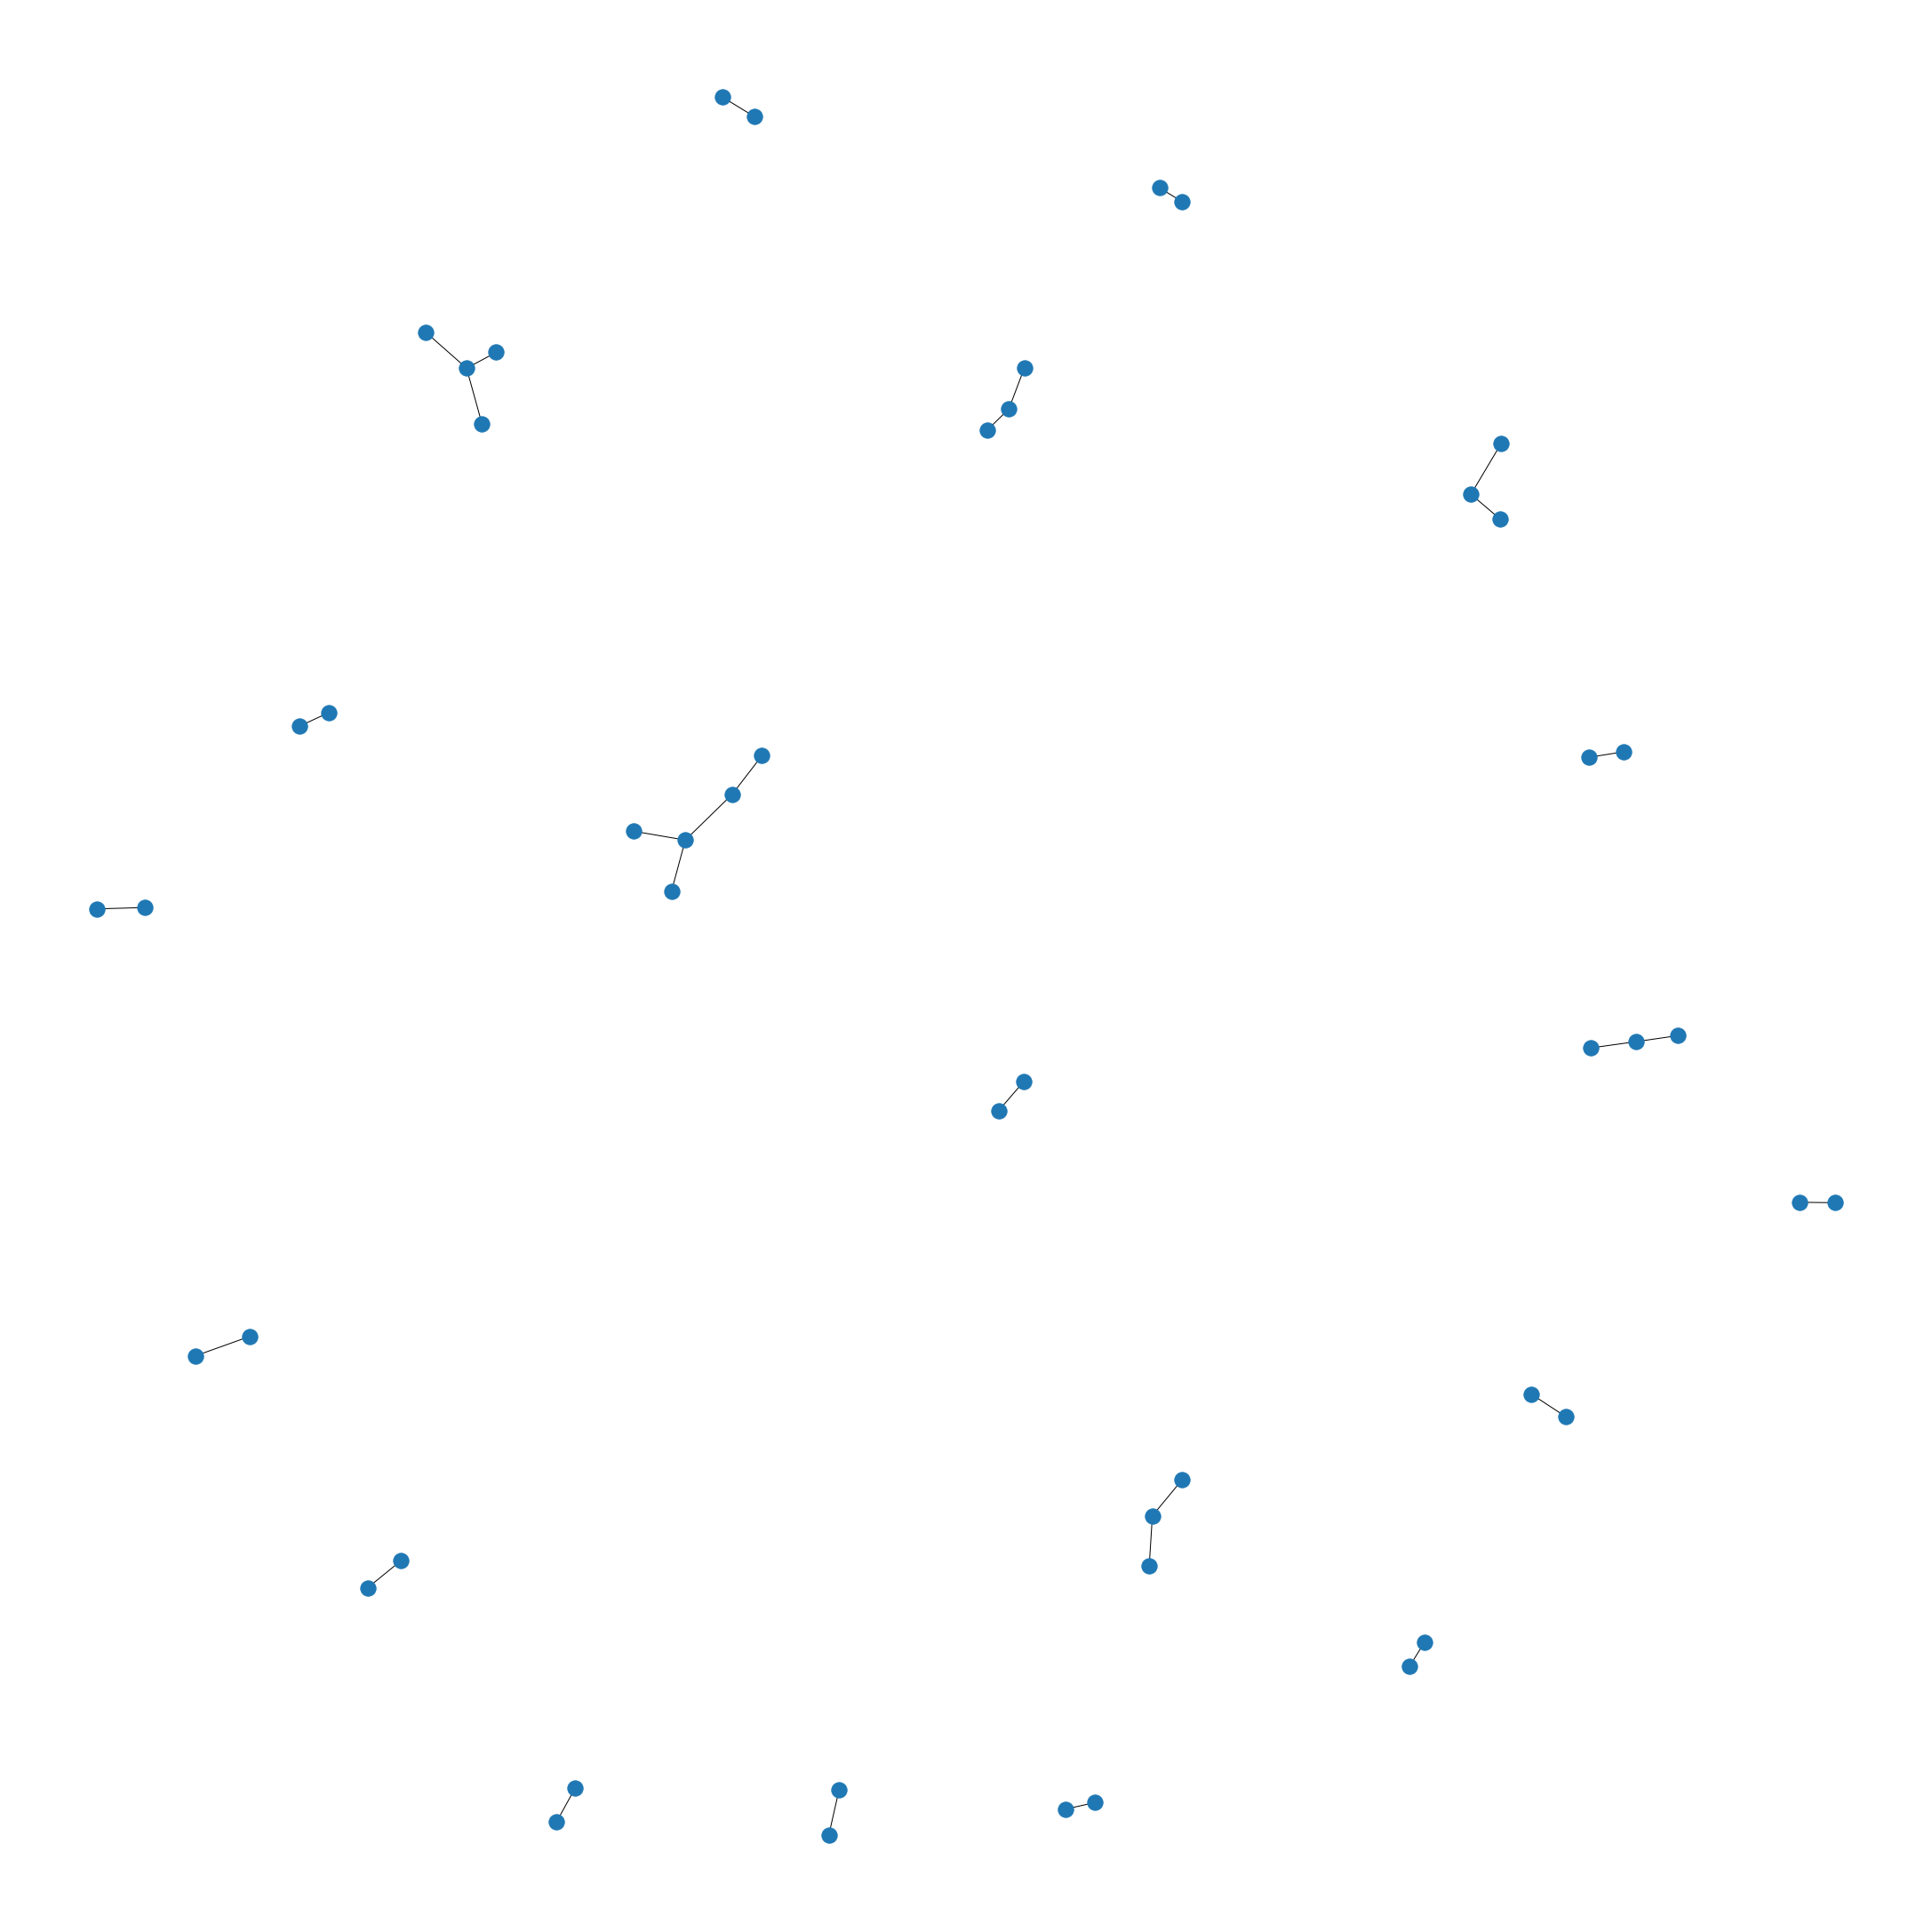

In [348]:
sub_graphs = trim_edges(gc)
plt.figure(figsize=(30,30)) 
nx.draw(sub_graphs)

# Application of the Island Method

After we remove all of the links with a weight of 0.058, the network breaks out into 818 island subgraphs, which all represent a group of people who are linked via incidences.  These graphs would include a significant amount of individuals who are connected via a few incidences or a siginificant amount of people are connected to those incidences.  

There are at least 10 graphs where individuals are conistently connected.  This could possibly indicate some type of organized crime or individuals who are repeatedly involved in the same type of incident.  

In [352]:
cc = list(gc.subgraph(c) for c in sorted(nx.connected_components(gc), key=len, reverse=True))[0]
islands=island_method(cc)
for i in islands:
    print(i[0], len(i[1]), 
          len(list(i[1].subgraph(c) for c in sorted(nx.connected_components(i[1]), key=len, reverse=True))))

0.05882352941176471 818 13
0.9470588235294118 252 65
1.835294117647059 30 14
2.723529411764706 10 5
3.611764705882353 4 2
